# Image encryption in the audio file

### Aphex Twin’s Devil Face

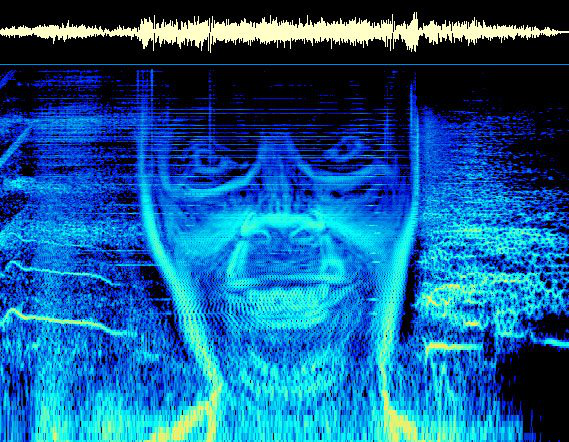

In [3]:
im = Image.open('aphex.1.jpg')
im

In [1]:
!pip install pydub

In [10]:
!pip install mpi4py

In [2]:
import math  # For cosine
import struct  # For WAVE file format
import time  # For timestamps
import wave  # For WAVE file format

import numpy as np  # For manipulating matrix
import scipy.ndimage  # For resampling
from PIL import Image  # For loading images
from pydub import AudioSegment  # For mixing two soundtracks
from tqdm import tqdm  # For progress bar

import matplotlib.pyplot as plt

In [11]:
from scipy import signal
from scipy.io import wavfile

from time import time

## Functions

In [2]:
def load_image(file):
    '''
    loads the image, converts it to gray-scale, flips it along vertical axis
    and changes the intensity to [0,2**15-1]
    '''
    img = Image.open(file)
    img = img.convert('L') #convert image to gray-scale

    img_arr = np.array(img)
    img_arr = np.flip(img_arr, axis=0)

    img_arr -= np.min(img_arr)
    img_arr = img_arr/np.max(img_arr)*(2**15-1)

    return img_arr

In [3]:
def resize_image(img_arr, size):
    '''
    resizes image to [size[0],size[1]]
    '''
    if not size[0]:
        size[0] = img_arr.shape[0]
    if not size[1]:
        size[1] = img_arr.shape[1]

    resampling_factor = size[0]/img_arr.shape[0], size[1]/img_arr.shape[1]

    # Order : 0=nearestNeighbour, 1:bilinear, 2:cubic etc...
    img_arr = scipy.ndimage.zoom(img_arr, resampling_factor, order=0)

    return img_arr

In [4]:
def preprocess_image(img_arr):
    '''
    does nothing (for now)
    '''
    # Inverse filter
    # img_arr = 1 - img_arr
    return img_arr

In [4]:
def generate_soundwave(file, output, duration=2.5, sample_rate=44100.0, min_freq=16000, max_freq=22000):
    '''
    main function of this code
    '''
    waveform = wave.open(output, 'w')
    waveform.setnchannels(1)  # mono
    waveform.setsampwidth(2)
    waveform.setframerate(sample_rate) #Set the frame rate to sample_rate

    total_frame_count = int(duration * sample_rate)

    step_size = 100
    substep_size = 250

    freq_range = max_freq - min_freq
    stepping_spectrum = int(freq_range / step_size)

    img_arr = load_image(file)
#     img_arr = preprocess_image(img_arr)
    img_arr = resize_image(img_arr, size=(stepping_spectrum, total_frame_count))

    data=[None]*total_frame_count
    for frame in tqdm(range(total_frame_count)):
        signal_val, count = 0, 0

        for step in range(stepping_spectrum):
            intensity = img_arr[step, frame]

            current_freq = (step * step_size) + min_freq
            next_freq = ((step+1) * step_size) + min_freq

            if next_freq - min_freq > max_freq:  # End of the spectrum
                next_freq = max_freq
            #Fourier transformation
            for freq in range(current_freq, next_freq, substep_size):
                signal_val += intensity * math.cos(2 * math.pi * freq * frame/sample_rate)
                count += 1
        if count == 0:
            count = 1
        signal_val /= count
        data[frame] = struct.pack('<h', int(signal_val))
    for frame in tqdm(range(len(data))):
        waveform.writeframesraw(data[frame]) # save 1 frame

    waveform.writeframes(''.encode()) #makes sure number of frames is correct
    waveform.close()

In [16]:
def mix_soundtracks(file1, file2, output_file, duration):
    sound1 = AudioSegment.from_file(file1,duration = duration)
    sound2 = AudioSegment.from_file(file2,duration = duration)

    # mix sound2 with sound1, starting at (start)ms into sound1)
    output = sound1.overlay(sound2, position=0)

    # save the result
    output.export(output_file, format=output_file.split('.')[-1])

### Main body of the program

In [18]:
# Input files
file = 'rick.png'
music = 'data_music.mp3'

# Output files
img_sound_output = 'img_sound_unparellelized.wav'
final_output = 'final_sound_unparellelized.wav'

generate_soundwave(file=file,
                    output=img_sound_output,
                    duration=10.5,
                    sample_rate=44100.0,
                    min_freq=16000,
                    max_freq=22000)

print("Image to waveform ended successfully")
mix_soundtracks(music, img_sound_output, final_output, duration=10.5)
print("Mixing ended successfully")
print("Done.")

100%|██████████| 463050/463050 [00:00<00:00, 918942.23it/s]


Image to waveform ended successfully
Mixing ended successfully
Done.


## Encryption of the image into the music for Rick Astley

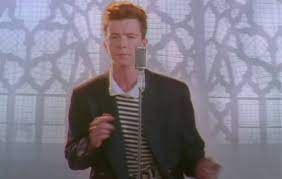

In [55]:
im = Image.open('rick.png')
im

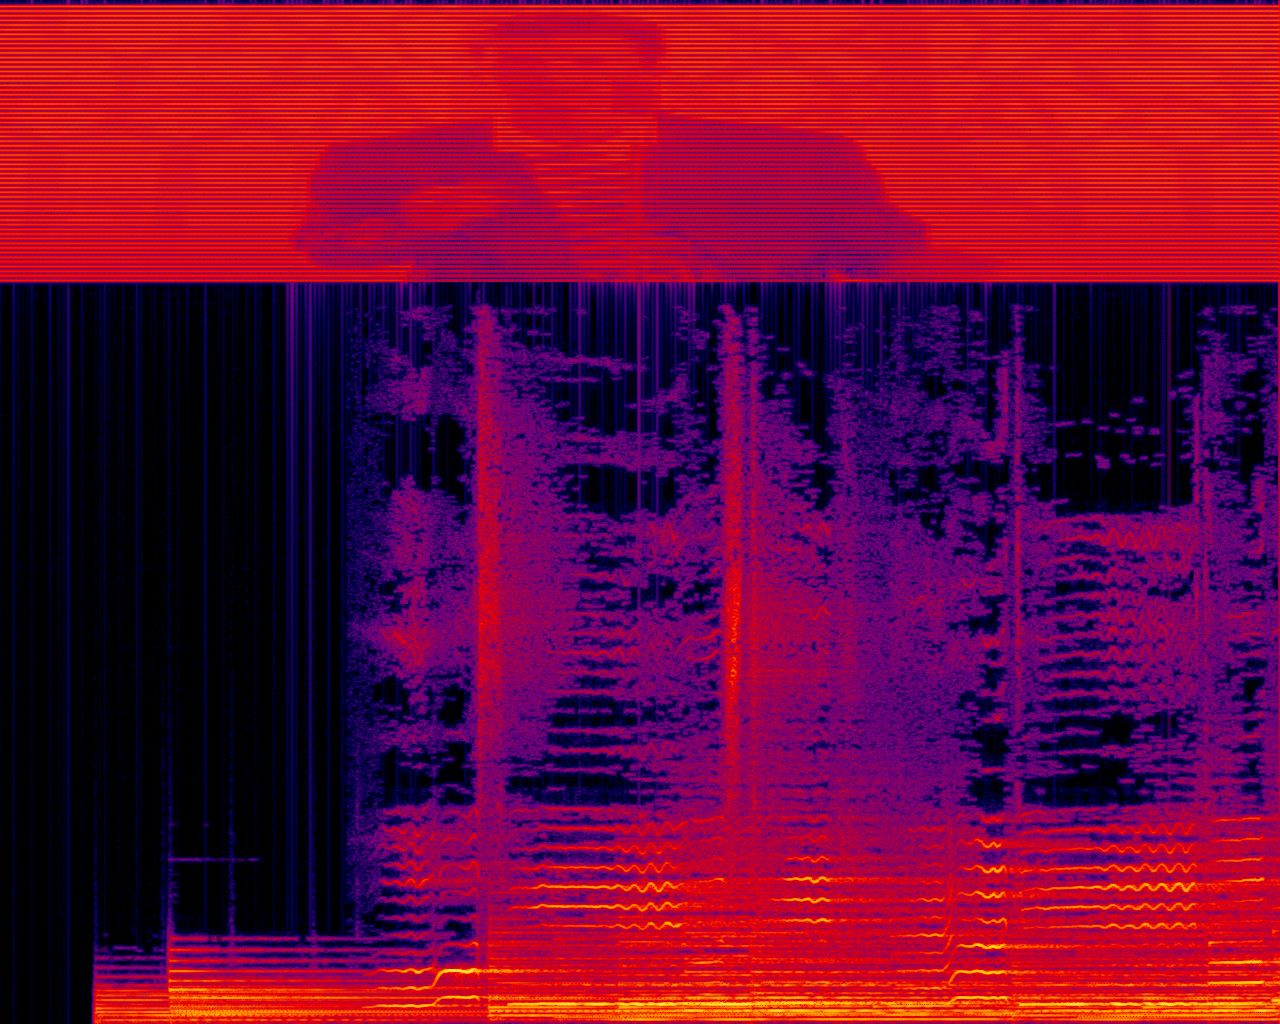

In [23]:
im = Image.open('final_sound_unparellelized.png')
im

In [33]:
song = AudioSegment.from_wav("final_sound_unparellelized.wav")
song

## Parallelization via MPI

In [53]:
%%writefile project.py
#######################
from mpi4py import MPI
#######################

import math  # For cosine
import struct  # For WAVE file format
import time  # For timestamps
import wave  # For WAVE file format

import numpy as np  # For manipulating matrix
import scipy.ndimage  # For resampling
from PIL import Image  # For loading images
from pydub import AudioSegment  # For mixing two soundtracks
# from tqdm import tqdm  # For progress bar

import matplotlib.pyplot as plt
from os import sys
#------------------------------------------------------------------------------
def load_image(file):
    img = Image.open(file)
    img = img.convert('L') #convert image to gray-scale
    
    img_arr = np.array(img)
    img_arr = np.flip(img_arr, axis=0)
    img_arr -= np.min(img_arr)
    img_arr = img_arr/np.max(img_arr)*(2**15-1)

    return img_arr
#------------------------------------------------------------------------------
def resize_image(img_arr, size):
    if not size[0]:
        size[0] = img_arr.shape[0]
    if not size[1]:
        size[1] = img_arr.shape[1]

    resampling_factor = size[0]/img_arr.shape[0], size[1]/img_arr.shape[1]

    # Order : 0=nearestNeighbour, 1:bilinear, 2:cubic etc...
    img_arr = scipy.ndimage.zoom(img_arr, resampling_factor, order=0)

    return img_arr
#------------------------------------------------------------------------------
def preprocess_image(img_arr):
    # Inverse filter
    # img_arr = 1 - img_arr
    return img_arr
#------------------------------------------------------------------------------
#########################
comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()
#########################
#------------------------------------------------------------------------------
def generate_soundwave(file, output, duration=2.5, sample_rate=44100.0, 
                       min_freq=0, max_freq=22000,size=1,rank=1):
    waveform = wave.open(output, 'w')
    waveform.setnchannels(1)  # mono
    waveform.setsampwidth(2)  
    waveform.setframerate(sample_rate) #Set the frame rate to sample_rate

    total_frame_count = int(duration * sample_rate)

    step_size = 100  # Works well in most cases
    substep_size = 250  # Works well in most cases

    freq_range = max_freq - min_freq
    stepping_spectrum = int(freq_range / step_size)

    img_arr = load_image(file)

    img_arr = preprocess_image(img_arr)
    img_arr = resize_image(img_arr, size=(stepping_spectrum, total_frame_count))
    #########################
    img_arr = np.array_split(img_arr,size,axis=1)[rank]
    #########################
    # total_frame_count -> img_arr.shape[1]
    #########################
    data=[None]*img_arr.shape[1]
    for frame in range(img_arr.shape[1]):
        signal_val, count = 0, 0

        for step in range(stepping_spectrum):
            intensity = img_arr[step, frame]

            current_freq = (step * step_size) + min_freq
            next_freq = ((step+1) * step_size) + min_freq

            if next_freq - min_freq > max_freq:  # End of the spectrum
                next_freq = max_freq

            for freq in range(current_freq, next_freq, substep_size):
                signal_val += intensity * math.cos(2 * math.pi * freq * frame/sample_rate)
                count += 1
        if count == 0:
            count = 1
        signal_val /= count
        data[frame] = struct.pack('<h', int(signal_val))
    for frame in range(len(data)):
        waveform.writeframesraw(data[frame]) # save 1 frame
#     waveform.writeframes(''.encode()) #makes sure number of frames is correct
    waveform.close()
#------------------------------------------------------------------------------
def mix_soundtracks(file1, file2, output_file, start=0):
    sound1 = AudioSegment.from_file(file1)
    sound2 = AudioSegment.from_file(file2)

    # mix sound2 with sound1, starting at (start)ms into sound1)
    output = sound1.overlay(sound2, position=start)

    # save the result
    output.export(output_file, format=output_file.split('.')[-1])
#------------------------------------------------------------------------------

# Input files
file  = f'{sys.argv[1]}'
music = 'data_music.mp3'

# Output files
img_sound_output = 'img_sound_{}.wav'.format(size)#str(int(time.time()))[-5:]
img_sound_output_per_rank = 'img_sound_temp_{}_{}.wav'.format(rank,str(int(time.time()))[-5:])

final_output = 'final_sound_{}.wav'.format(size)#str(int(time.time()))[-5:]

generate_soundwave(file=file,
                    output=img_sound_output_per_rank,
                    duration=10.5,
                    sample_rate=44100.0,
                    min_freq=0,
                    max_freq=22000,
                    size=size,
                    rank=rank)

#########################
sound = AudioSegment.from_wav(img_sound_output_per_rank)
sound_arr=comm.gather(sound, root=0)
if rank==0:
    sound = sum(sound_arr)
    sound.export(img_sound_output, format="wav")
    mix_soundtracks(music, img_sound_output, final_output)
#########################

Overwriting project.py


In [35]:
# !mpiexec -n 4 python project.py rick.png
# !rm *temp*.wav

In [3]:
def plot_spectrogram(size): 
    sample_rate, samples = wavfile.read('img_sound_{}.wav'.format(size))
    frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)

    plt.imshow(spectrogram,origin='lower',aspect='auto',
               extent=[int(times[0])-0.5,int(times[-1])-0.5,int(frequencies[0])-0.5,int(frequencies[-1])-0.5])
    plt.title('Spectrogram for {} processes'.format(size))
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')

    plt.show()

## Results of parallelization

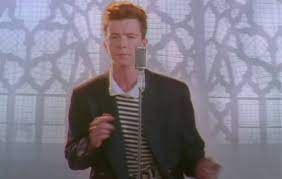

In [35]:
im = Image.open('rick.png')
im

### Parallelization for MPI on threads

Time: 96.258     Processes: 1


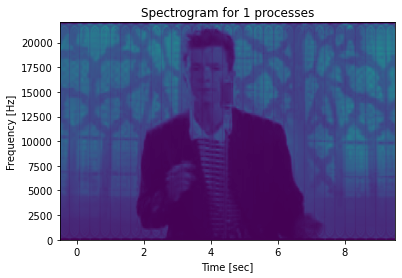

Time: 98.671     Processes: 2


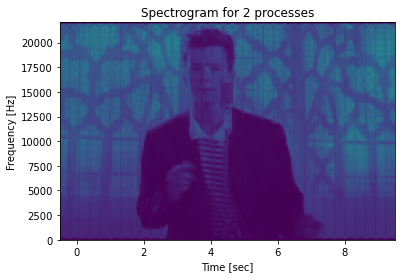

Time: 36.498     Processes: 3


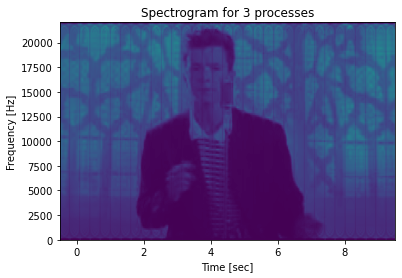

Time: 27.374     Processes: 4


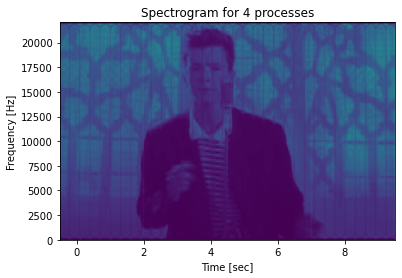

Time: 36.244     Processes: 5


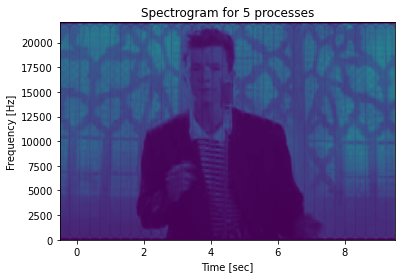

Time: 35.121     Processes: 6


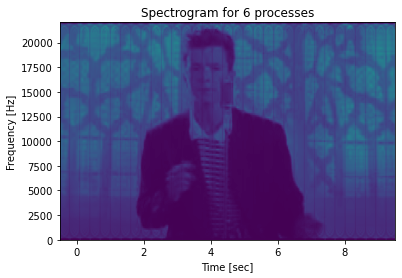

Time: 32.196     Processes: 7


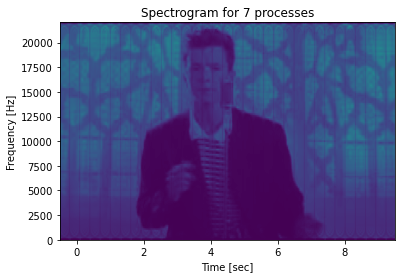

Time: 32.230     Processes: 8


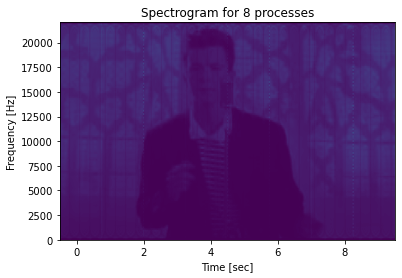

In [17]:
T1 = []
for i in range(1,9):
    t_start = time()
    !mpiexec -n {i} --use-hwthread-cpus python project.py rick.png
    t_end = time()
    T1.append(t_end-t_start)
    !rm *temp*.wav
    print('Time: {:6.3f}     Processes: {}'.format(T1[-1],i))
    plot_spectrogram(i)

### Speedup

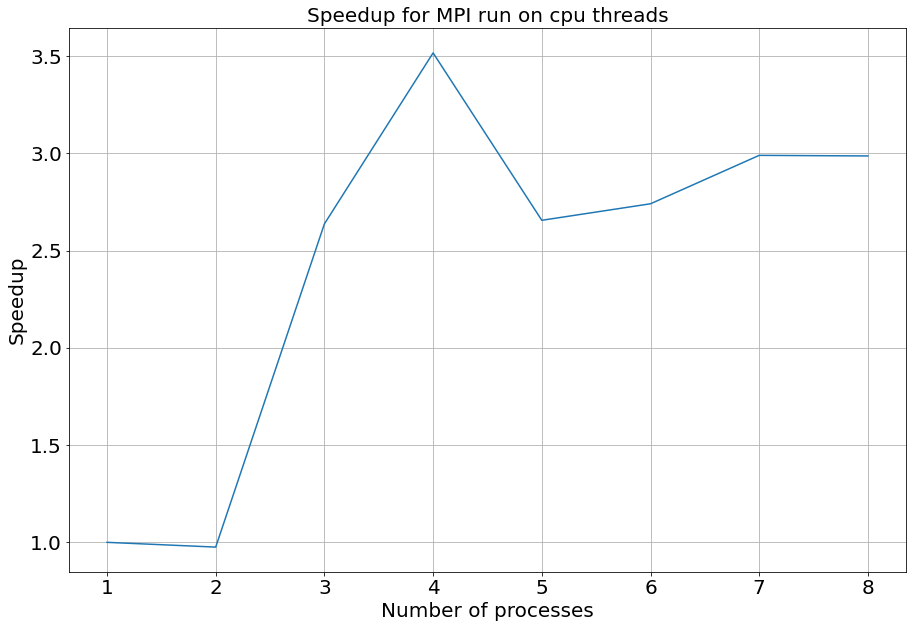

In [19]:
plt.figure(figsize=(15,10))
plt.plot(range(1,9), [T1[0]/i for i in T1])
plt.xlabel('Number of processes', fontsize=20)
plt.ylabel('Speedup', fontsize=20)
plt.title("Speedup for MPI run on cpu threads", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid();

In [16]:
T2 = []
for i in range(1,5):
    t_start = time()
    !mpiexec -n {i} python project.py rick.png
    t_end = time()
    T2.append(t_end-t_start)
    !rm *temp*.wav
    print('Time: {:6.3f}     Processes: {}'.format(T2[-1],i))
#     plot_spectrogram(i)

Time: 102.825     Processes: 1
Time: 54.238     Processes: 2
Time: 39.625     Processes: 3
Time: 29.617     Processes: 4


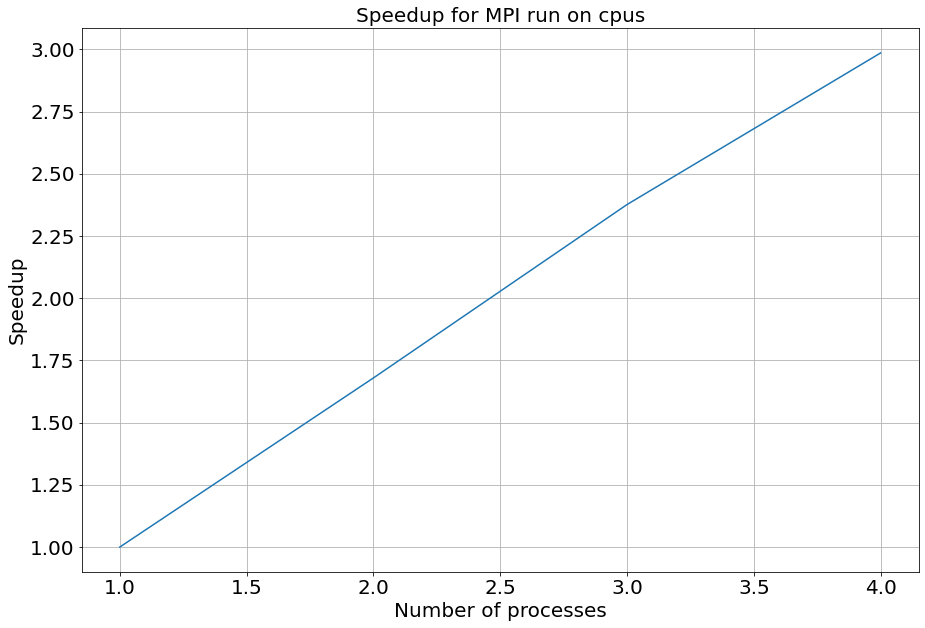

In [15]:
plt.figure(figsize=(15,10))
plt.plot(range(1,5), [T2[0]/i for i in T2])
plt.xlabel('Number of processes', fontsize=20)
plt.ylabel('Speedup', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title("Speedup for MPI run on cpus", fontsize=20)
plt.grid();

## Examples of spectrograms

### Horse

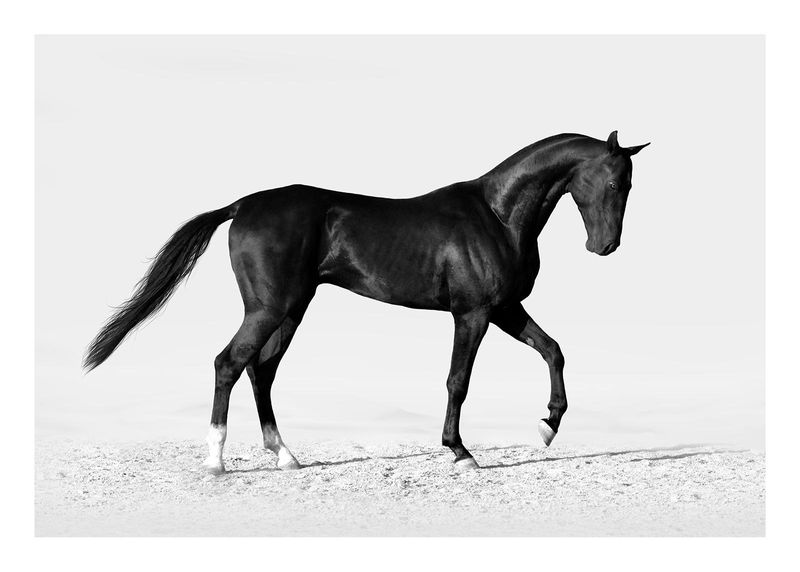

In [44]:
im = Image.open('black-horse.jpg')
im

In [46]:
im.close()

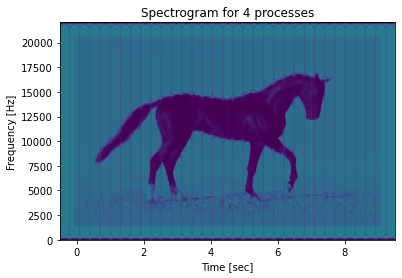

In [54]:
!mpiexec -n 4 python project.py black-horse.jpg
!rm *temp*.wav
plot_spectrogram(4)

### Cat in hat

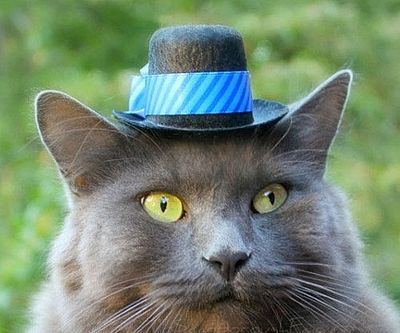

In [47]:
im = Image.open('hats-for-cats.jpg')
im

In [48]:
im.close()

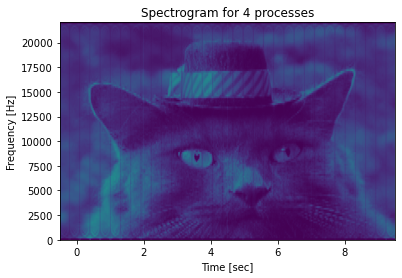

In [38]:
!mpiexec -n 4 python project.py hats-for-cats.jpg
!rm *temp*.wav
plot_spectrogram(4)

# Thanks for attention